In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt


2025-10-22 19:06:20.613003: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-22 19:06:20.657637: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-22 19:06:21.921330: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [2]:

# Define constants
IMAGE_WIDTH, IMAGE_HEIGHT = 128, 128  # Roboflow default size is often 416x416, but 128x128 is good for a start
BATCH_SIZE = 32
EPOCHS = 20  # You can increase this for better training
NUM_CLASSES = 6  # Unlabeled, angry, attentive, no clear emotion recognizable, relaxed, sad, uncomfortable
DATA_DIR = "/home/qod120/Documents/project/2nd_ai_web_project/ai_model/Cat Emotions.v2i.multiclass/train"
CSV_FILE = os.path.join(DATA_DIR, "_classes.csv")


In [3]:

def create_mobilenet_model(input_shape, num_classes):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the convolutional base

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [4]:

def load_data(csv_file, data_dir, image_width, image_height):
    df = pd.read_csv(csv_file)
    
    # Drop the 'Unlabeled' column if it's not a class we want to predict, or if it's always 0
    # Based on the CSV content, 'Unlabeled' seems to be a class itself.
    # Let's assume all columns except 'filename' are emotion classes.
    
    class_columns = df.columns.drop('filename').tolist()
    
    # Ensure that each row has exactly one '1' for multi-class classification
    # If there are rows with multiple '1's or no '1's, this needs to be handled
    # For now, we assume it's clean one-hot encoding.
    
    # Convert the DataFrame to a format suitable for flow_from_dataframe
    # The 'y_col' should be a list of class columns
    
    # Create a list of filenames with their full paths
    df['filename'] = df['filename'].apply(lambda x: os.path.join(data_dir, x))
    
    return df, class_columns


In [5]:

def prepare_data(csv_file, data_dir, image_width, image_height, batch_size):
    df, class_columns = load_data(csv_file, data_dir, image_width, image_height)
    
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    
    validation_split_ratio = 0.2
    validation_samples = int(len(df) * validation_split_ratio)
    
    train_df = df.iloc[validation_samples:]
    validation_df = df.iloc[:validation_samples]
    
    num_classes = len(class_columns)
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=True
    )

    validation_generator = validation_datagen.flow_from_dataframe(
        dataframe=validation_df,
        x_col='filename',
        y_col=class_columns,
        target_size=(image_width, image_height),
        batch_size=batch_size,
        class_mode='raw',
        shuffle=False
    )
    return train_generator, validation_generator, class_columns, num_classes


In [6]:

def build_and_compile_model(input_shape, num_classes):
    model = create_mobilenet_model(input_shape, num_classes)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model


In [7]:

def train_and_save_model(model, train_generator, validation_generator, epochs, batch_size):
    history = model.fit(
        train_generator,
        steps_per_epoch=int(np.ceil(train_generator.samples / batch_size)),
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=int(np.ceil(validation_generator.samples / batch_size))
    )
    model.save("cat_emotion_mobilenet_model.h5") # Changed model name
    print("Model trained and saved as cat_emotion_mobilenet_model.h5")
    return history


In [8]:

def evaluate_and_display_predictions(model_path, validation_generator, class_columns):
    loaded_model = tf.keras.models.load_model(model_path)

    validation_images, validation_labels = next(validation_generator)
    predictions = loaded_model.predict(validation_images)

    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(validation_images))):
        plt.subplot(3, 3, i + 1)
        plt.imshow(validation_images[i])
        true_label = class_columns[np.argmax(validation_labels[i])]
        predicted_label = class_columns[np.argmax(predictions[i])]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()


Found 1657 validated image filenames.
Found 414 validated image filenames.


2025-10-22 19:06:22.995046: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,917,447 (11.13 MB)

 Trainable params: 659,463 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 22s 365ms/step - accuracy: 0.5365 - loss: 1.4492 - val_accuracy: 0.6280 - val_loss: 0.9526
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 338ms/step - accuracy: 0.6017 - loss: 0.9753 - val_accuracy: 0.6546 - val_loss: 0.9076
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 358ms/step - accuracy: 0.5969 - loss: 0.9546 - val_accuracy: 0.6256 - val_loss: 0.9318
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.6210 - loss: 0.8962 - val_accuracy: 0.6715 - val_loss: 0.9032
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 354ms/step - accuracy: 0.6258 - loss: 0.8991 - val_accuracy: 0.6763 - val_loss: 0.9522
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 364ms/step - accuracy: 0.6295 - loss: 0.8920 - val_accuracy: 0.7029 - val_loss: 0.9571
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.6234 - loss: 0.8733 - val_accuracy: 0.6787 - val_loss: 0.9426
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 18s 343ms/step - accuracy: 0.6409 - loss: 0.8546 - val_accu

Model trained and saved as cat_emotion_mobilenet_model.h5


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


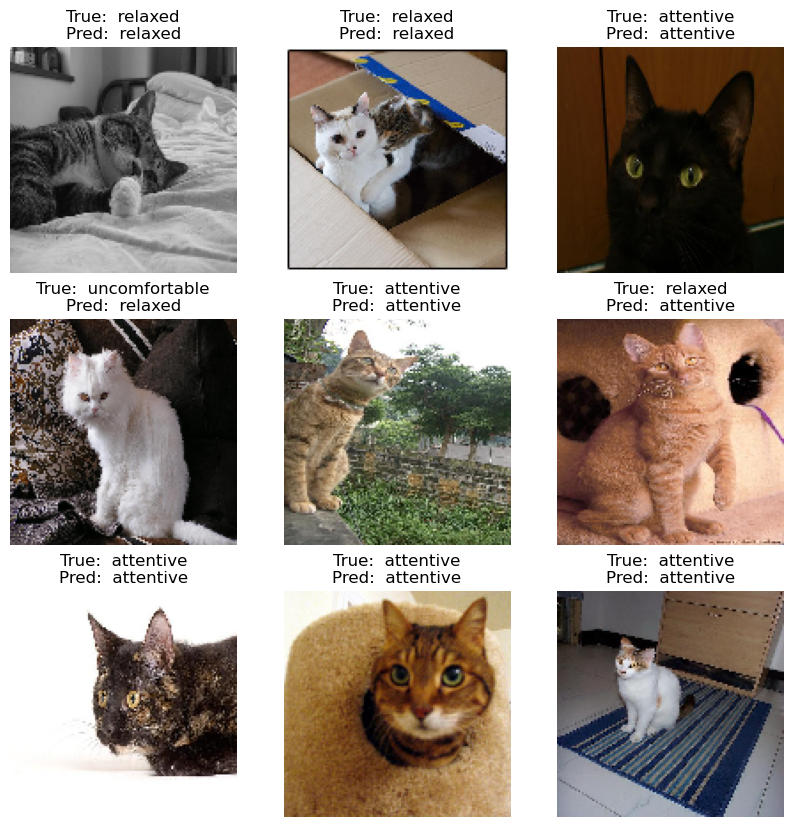

In [9]:

def train_model():
    train_generator, validation_generator, class_columns, num_classes = prepare_data(
        CSV_FILE, DATA_DIR, IMAGE_WIDTH, IMAGE_HEIGHT, BATCH_SIZE
    )
    
    model = build_and_compile_model((IMAGE_WIDTH, IMAGE_HEIGHT, 3), num_classes)
    
    train_and_save_model(model, train_generator, validation_generator, EPOCHS, BATCH_SIZE)
    
    evaluate_and_display_predictions("cat_emotion_mobilenet_model.h5", validation_generator, class_columns) # Changed model name

if __name__ == "__main__":
    train_model()
